## Import dependencies

In [1]:
import astropy.io.fits as fits
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
from monai.networks.nets import AttentionUnet
import torch

## Function that adds gaussian PSF at a random location on the image

In [2]:
def add_psf(initial_img):
    # Assume you already have a 100x100 numpy array
    grid = initial_img  # Replace with your existing array

    # Grid size
    grid_size = grid.shape[0]

    # Generate a 2D grid
    x = np.arange(0, grid_size, 1, dtype=np.float16)
    y = np.arange(0, grid_size, 1, dtype=np.float16)
    X, Y = np.meshgrid(x, y)

    # Randomly choose a center for the Gaussian
    mu_x = np.random.randint(0, grid_size)
    mu_y = np.random.randint(0, grid_size)

    # Define Gaussian parameters
    sigma = 3  # Standard deviation (spread of the PSF)
    amplitude = 4  # Peak intensity

    # Generate Gaussian function
    gaussian = amplitude * np.exp(-((X - mu_x)**2 + (Y - mu_y)**2) / (2 * sigma**2), dtype=np.float16)

    # Add the Gaussian spike to the existing grid
    grid += gaussian

    return grid

## Auxiliary functions

In [3]:
def display_image_single_image(ax, image, title='Image', save_path='output.png'):
    im = ax.imshow(image, cmap='gray', origin='lower')  # 'origin' ensures correct orientation
    plt.colorbar(im, ax=ax, label='Pixel Value')  # Use plt.colorbar and associate it with the axis
    ax.set_title(title)
    ax.set_xlabel('X Pixels')
    ax.set_ylabel('Y Pixels')

In [4]:
def display_image_grid(images):
    original_image, noisy_image, restored_image, difference_image = images
    _, ax = plt.subplots(2, 2, figsize=(16, 16))
    display_image_single_image(ax[0, 0], original_image, title='Original Image')
    display_image_single_image(ax[0, 1], noisy_image, title='Noisy Image')
    display_image_single_image(ax[1, 0], restored_image, title='Restored Image')
    display_image_single_image(ax[1, 1], difference_image, title='Difference Image')

In [5]:
def compute_entropy(array):
    # Flatten the array to 1D
    flattened_array = (array.flatten() * 100) + 100000  # Multiply by 1000 to avoid floating point errors
    
    # Compute the histogram (probability distribution)
    value_counts = np.bincount(flattened_array.astype(int))  # Count occurrences of each value
    probabilities = value_counts / len(flattened_array)  # Normalize to get probabilities
    
    # Remove zero probabilities to avoid log(0)
    probabilities = probabilities[probabilities > 0]
    
    # Compute entropy
    entropy = -np.sum(probabilities * np.log2(probabilities))
    return entropy

In [6]:
def plot_histogram(diff_image, model_type, bins=50):
    plt.figure(figsize=(8, 6))
    plt.hist(diff_image.flatten(), bins=bins, color='blue', alpha=0.7, edgecolor='black')
    plt.title(f"Histogram of diff_image Values {model_type}")
    plt.xlim([diff_image.min(), diff_image.max()])
    plt.yscale('log')  # Use a logarithmic scale for better visibility
    plt.xlabel("Pixel Value")
    plt.ylabel("Frequency")
    plt.grid(True)
    plt.show()

In [7]:
DATA_DIR = os.path.join(os.getcwd(), 'data')

raw_data = fits.open(os.path.join(DATA_DIR, 'f001a066.fits'))[0].data

norm_data = np.array(raw_data, dtype=np.float16) / raw_data.max()
resized_data = cv2.resize(norm_data, (512, 512), interpolation=cv2.INTER_CUBIC) #7040

def show_results(model, model_name: str, model_type: str):
    model.load_state_dict(torch.load(f'{model_name}.pth'))

    # Create a noisy image
    noisy_image = add_psf(resized_data.copy())
    noisy_image_tensor = torch.tensor(noisy_image, dtype=torch.float32).unsqueeze(0).unsqueeze(0).to('cpu')

    # Create a target image
    target_image = resized_data.copy()

    # Perform Deep-AGN Clean
    with torch.no_grad():
        restored_image_tensor = model(noisy_image_tensor)

    # Convert the restored image tensor to a numpy array
    restored_image_tensor = restored_image_tensor.to('cpu')
    restored_image_array = restored_image_tensor.squeeze().detach().numpy()

    # Create the difference image
    diff_image = np.array(target_image, dtype=np.float32) - np.array(restored_image_array, dtype=np.float32)

    print(f"{model_type} Std:", np.std(diff_image))
    print(f"{model_type} Entropy: ", compute_entropy(diff_image))

    size = diff_image.shape[0]
    uniform_array = np.random.uniform(0, 1, size=(size, size))

    print("Uniform Array Entropy: ", compute_entropy(uniform_array))
    
    display_image_grid([target_image, noisy_image, restored_image_array, diff_image])
    plot_histogram(diff_image, model_type)

## Defining the AttentionUnet

In [8]:
model = AttentionUnet(
    spatial_dims=2,  # Set to 3 for 3D inputs
    in_channels=1,   # Number of input channels
    out_channels=1,  # Number of output channels
    channels=(96, 128, 256, 512),  # Channels in each layer
    strides=(2, 2, 2),  # Strides for downsampling
    kernel_size=3,  # Convolution kernel size
    up_kernel_size=3,  # Upsampling kernel size
    dropout=0.1,  # Dropout rate
)

## The result for the AttentionUnet with a *Smooth L1 loss*

overflow encountered in square


Smooth L1 Std: 0.006496107
Smooth L1 Entropy:  1.4580758361521495
Uniform Array Entropy:  6.643589539028844


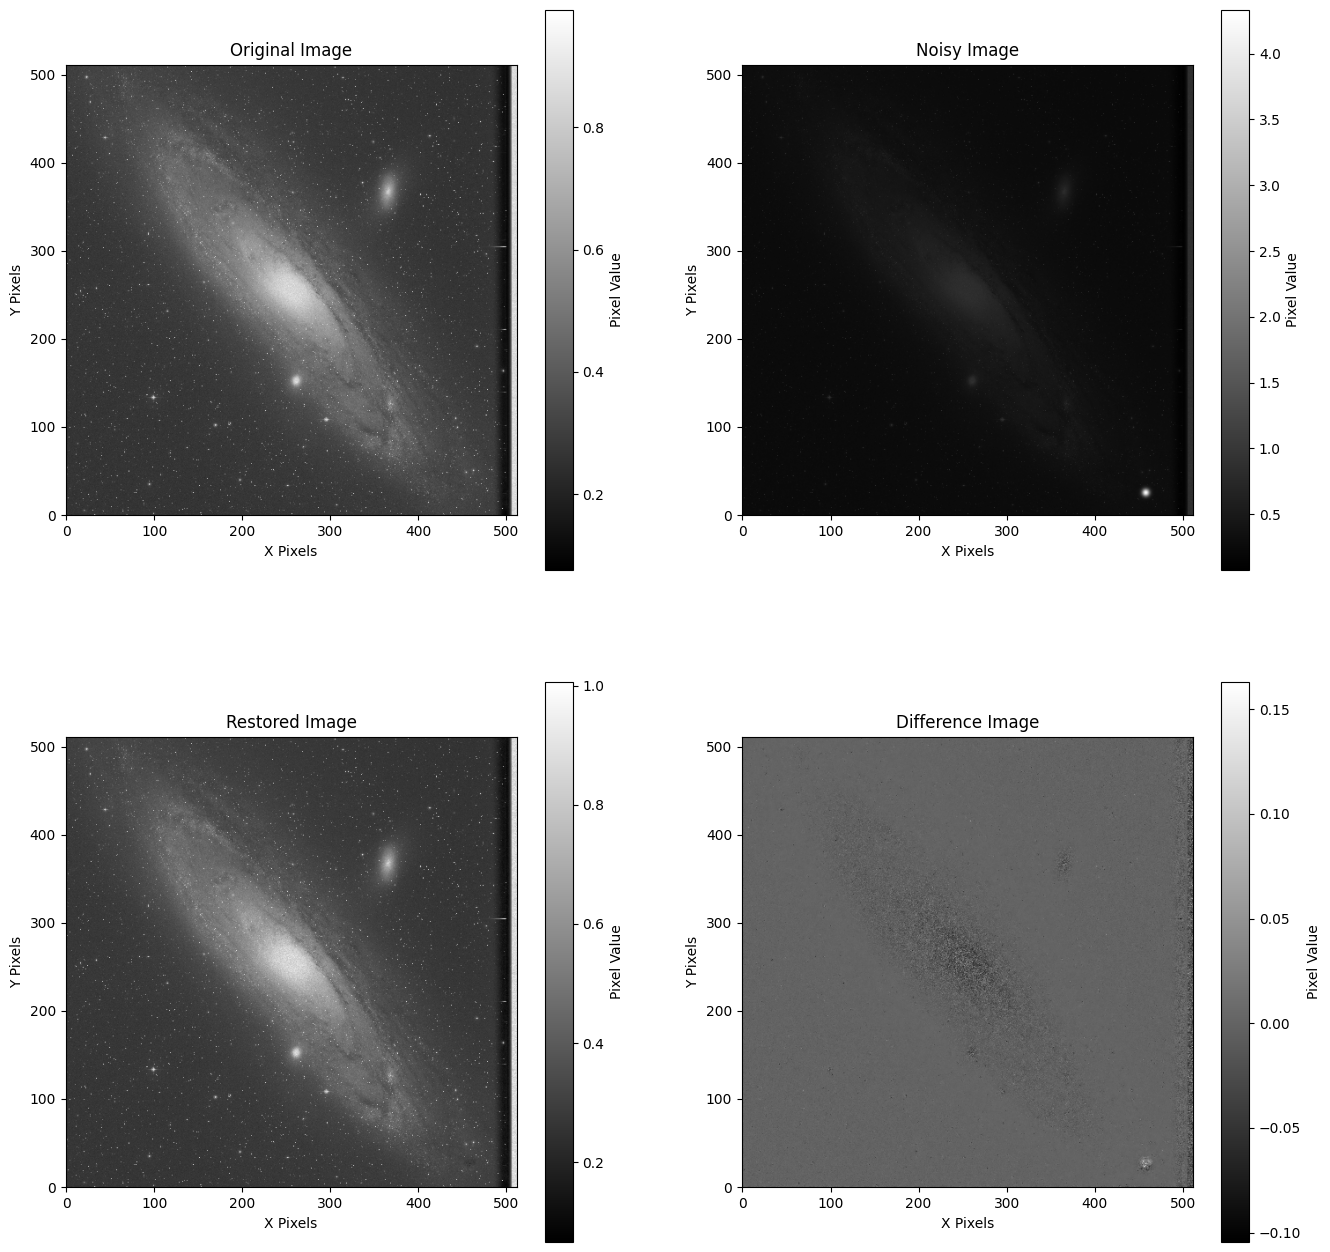

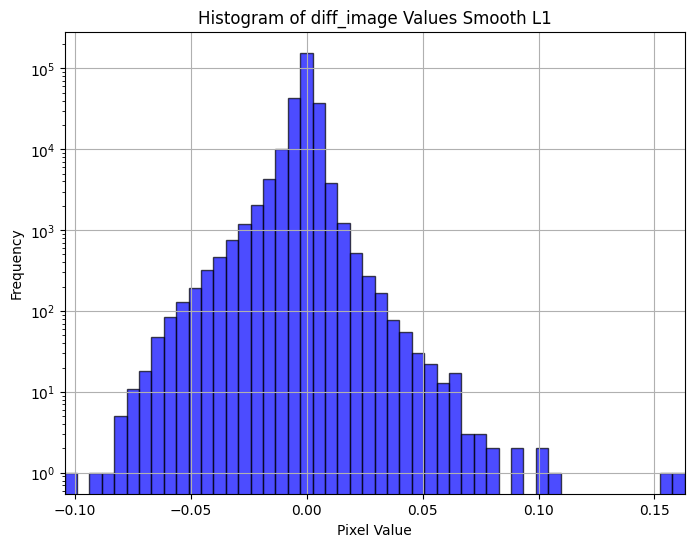

In [9]:
show_results(model, 'attention_unet_model_smooth_l1', "Smooth L1")

## The result for the AttentionUnet with a *MSE Loss* (BEST) 

overflow encountered in square


MSE Std: 0.005471541
MSE Entropy:  1.3719575128156465
Uniform Array Entropy:  6.643561329321298


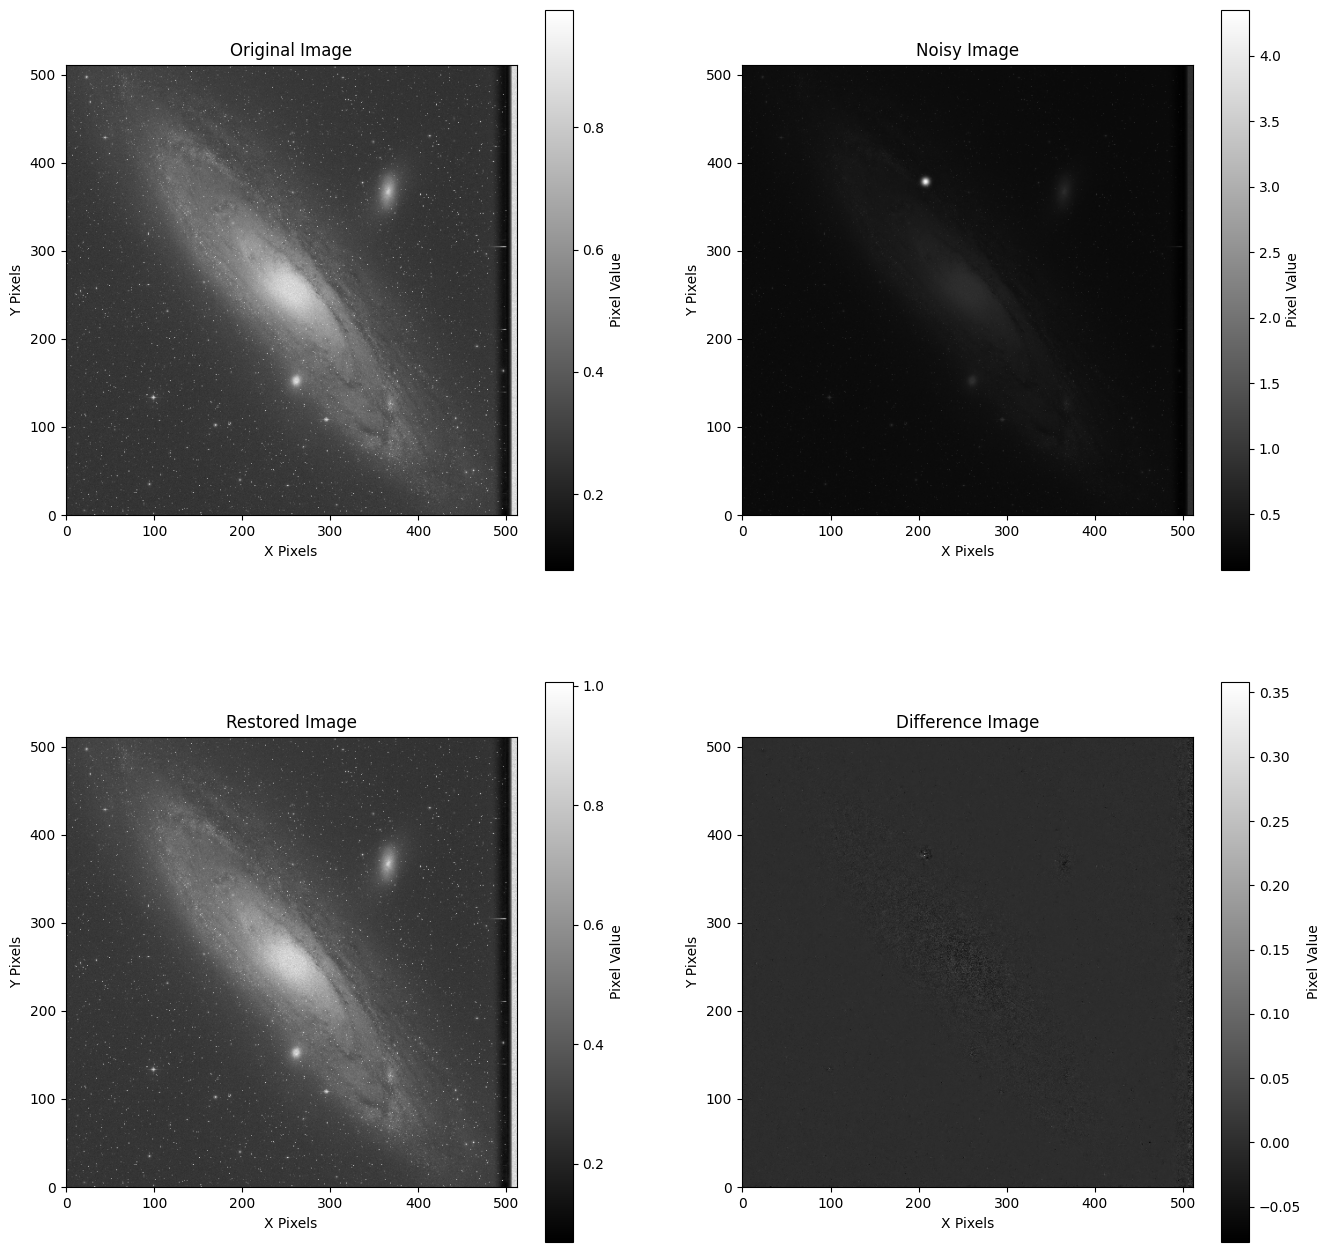

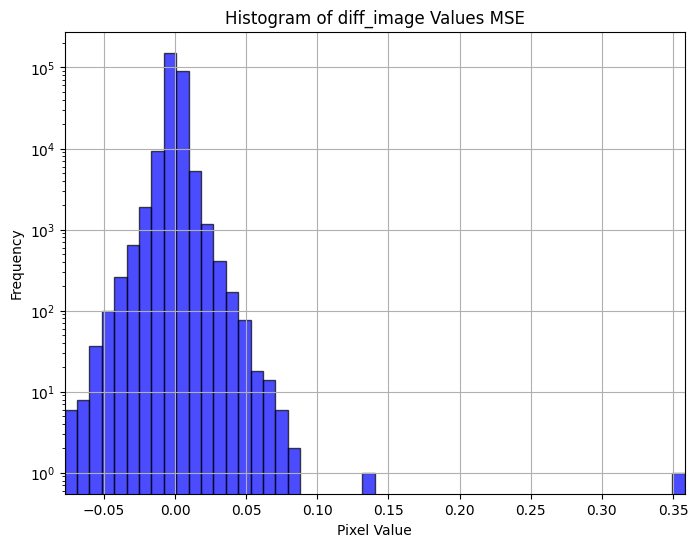

In [ ]:
show_results(model, 'attention_unet_model_mse', "MSE")

## Multi-objective loss functions

A multi-objective loss function is one that combines the weighted average of two losses of the same type, calculated on different objectives. The first loss represents the regular loss between the source and the target, while the second loss measures the discrepancy between the AGN (in the absence of background) and the difference between the input image (with AGN) and the model's prediction (cleaned image). Thus, the generic formula for any type of loss function can be expressed as:

$$
\mathcal{L} = \lambda \cdot \mathcal{L}_1 + (1 - \lambda) \cdot \mathcal{L}_2
$$

Where:
$\mathcal{L}_1$ is the regular loss between the source and the target, $\mathcal{L}_2$ is the loss between the AGN (with zero background) and the source's prediction, $\lambda$ is the weighting factor between the two losses.

## The result for the AttentionUnet with a *Multi-objective Smooth L1 loss*

overflow encountered in square
overflow encountered in add


Constrained Smooth L1 Std: 0.0062941536
Constrained Smooth L1 Entropy:  1.4272746626271315
Uniform Array Entropy:  6.643540747468648


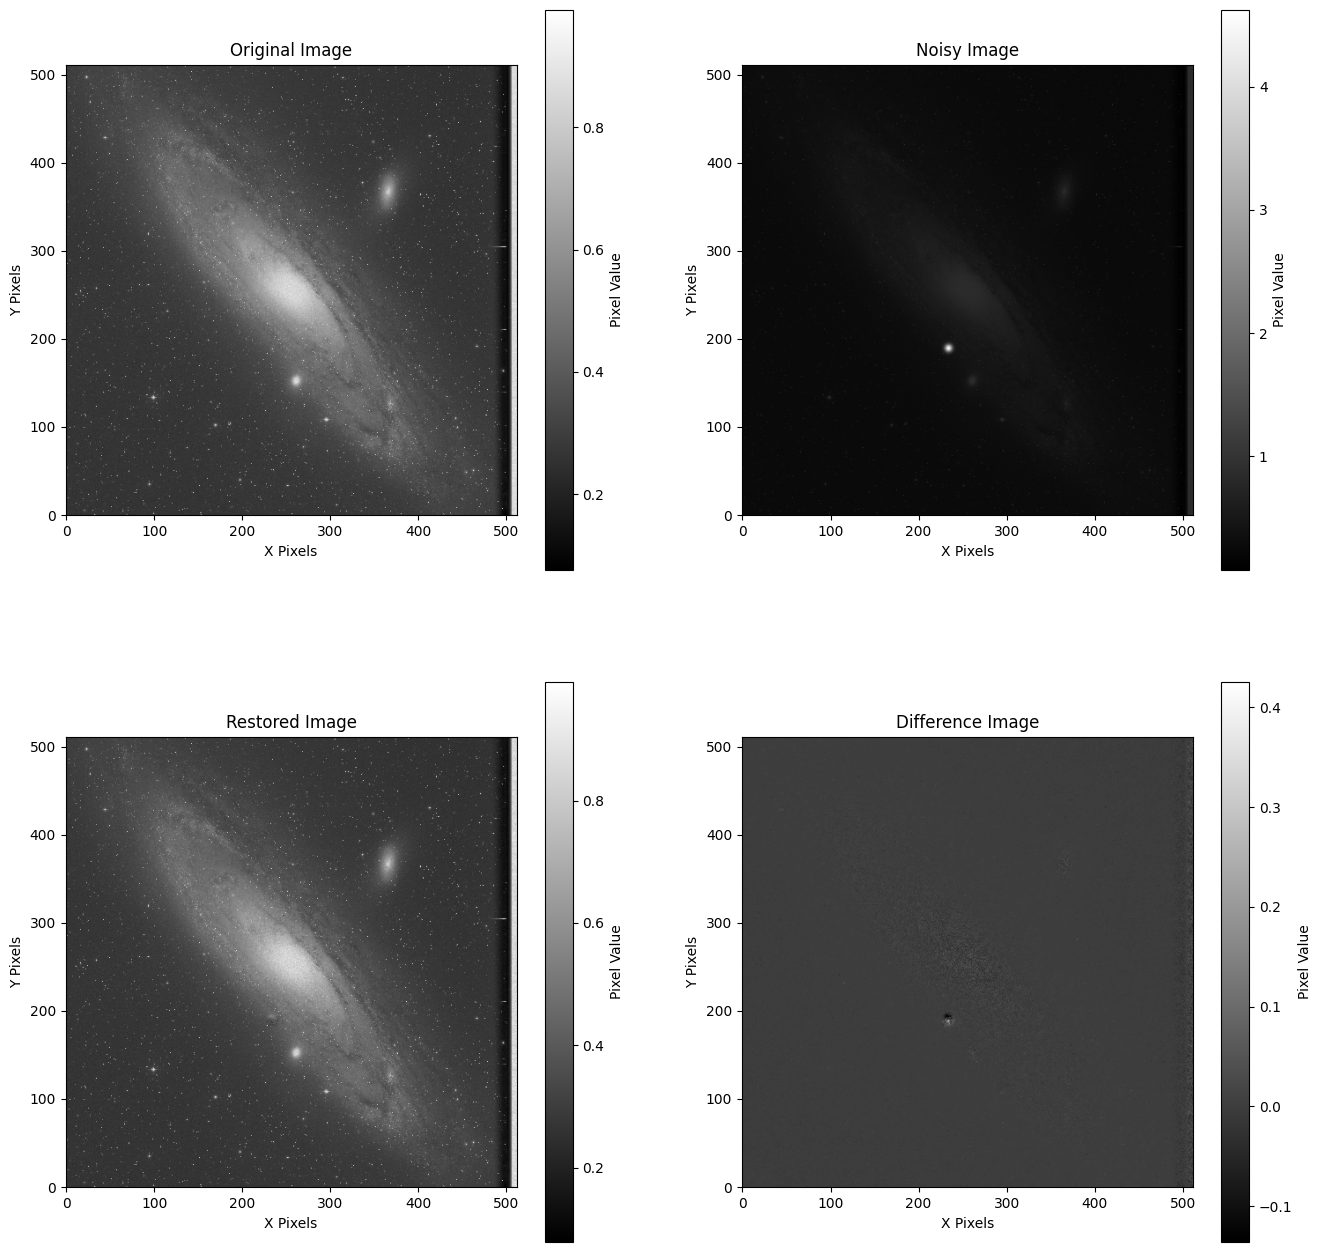

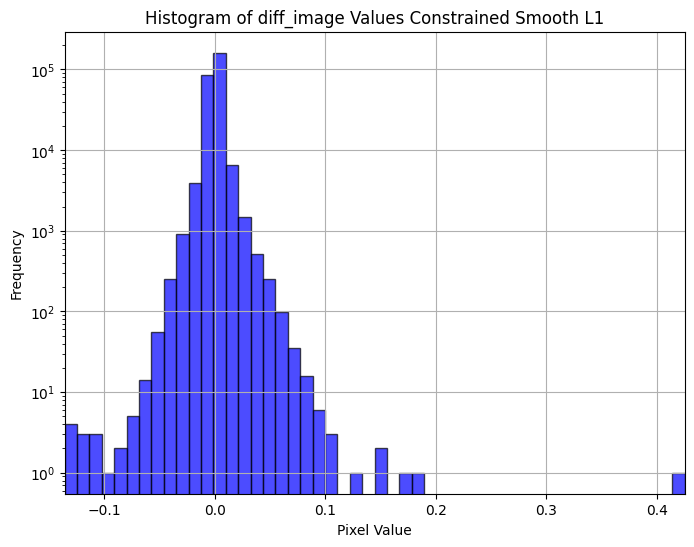

In [11]:
show_results(model, 'attention_unet_model_constrained_smooth_l1', "Constrained Smooth L1")

## The result for the AttentionUnet with a *Multi-objective MSE loss*

Constrained MSE Std: 0.0059654466
Constrained MSE Entropy:  1.3904682182291264
Uniform Array Entropy:  6.6436415377349345


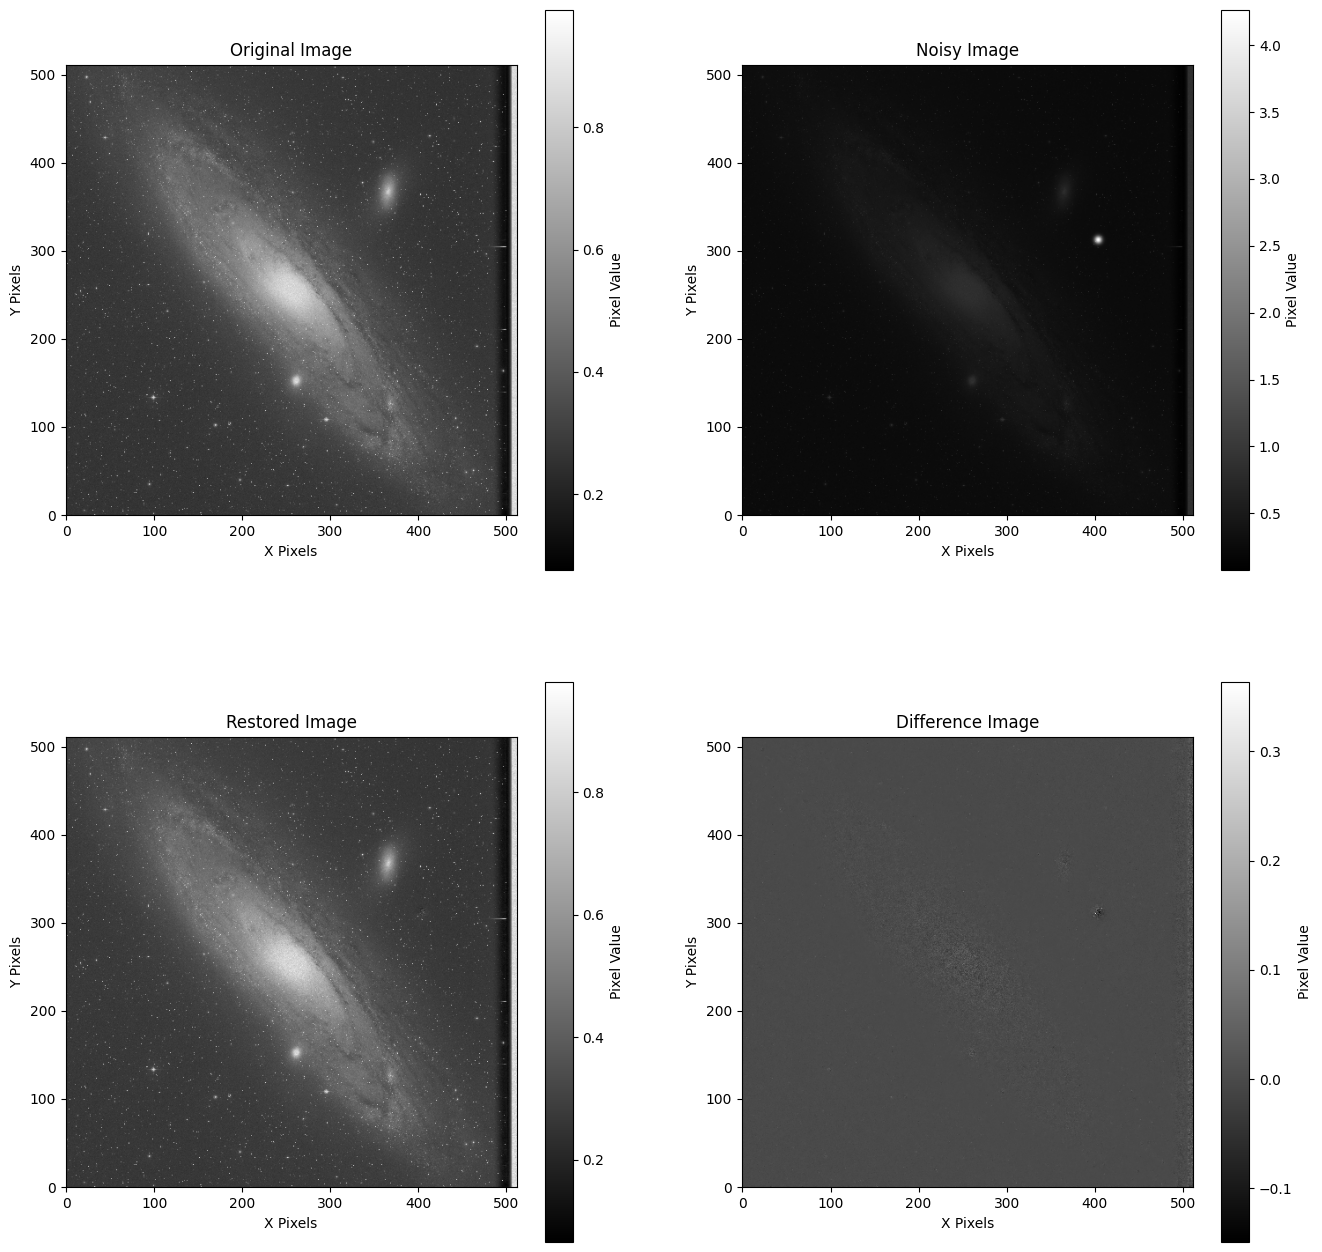

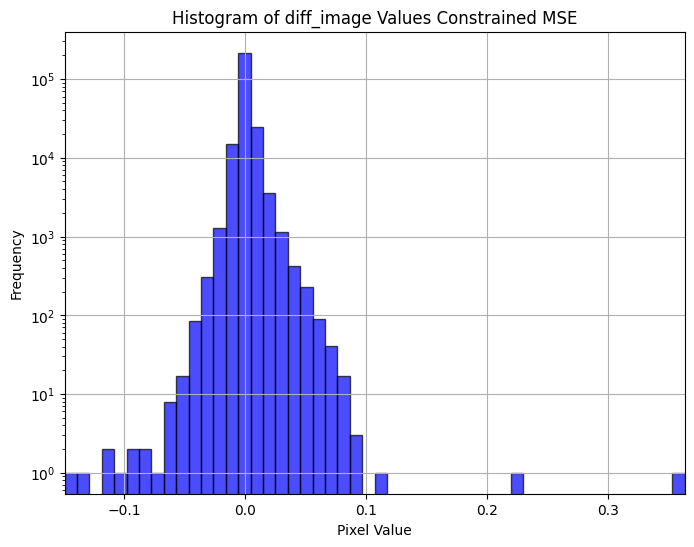

In [13]:
show_results(model, 'attention_unet_model_constrained_mse', "Constrained MSE")

## Evaluation comparing standard deviations

In [18]:
from tqdm import tqdm

def test_single_model(model, model_name: str):
    model.load_state_dict(torch.load(f'{model_name}.pth'))

    std_list = []
    for i in tqdm(range(50), desc=f"Testing {model_name}"):
        # Create a noisy image
        noisy_image = add_psf(resized_data.copy())
        noisy_image_tensor = torch.tensor(noisy_image, dtype=torch.float32).unsqueeze(0).unsqueeze(0).to('cpu')

        # Create a target image
        target_image = resized_data.copy()

        # Perform Deep-AGN Clean
        with torch.no_grad():
            restored_image_tensor = model(noisy_image_tensor)

        # Convert the restored image tensor to a numpy array
        restored_image_tensor = restored_image_tensor.to('cpu')
        restored_image_array = restored_image_tensor.squeeze().detach().numpy()

        # Create the difference image
        diff_image = np.array(target_image, dtype=np.float32) - np.array(restored_image_array, dtype=np.float32)

        std = np.std(diff_image)
        std_list.append(std)
    return np.array(std_list)

In [19]:
def test_all_models():
    std_mse = test_single_model(model, 'attention_unet_model_mse')
    std_smooth_l1 = test_single_model(model, 'attention_unet_model_smooth_l1')
    std_constrained_mse = test_single_model(model, 'attention_unet_model_constrained_mse')
    std_constrained_smooth_l1 = test_single_model(model, 'attention_unet_model_constrained_smooth_l1')

    fig, ax = plt.subplots(2, 2, figsize=(16, 16))
    ax[0, 0].hist(std_mse, bins=50, color='blue', alpha=0.7, edgecolor='black', label='MSE mean: {:.2f}'.format(np.mean(std_mse)))
    ax[0, 0].set_title("MSE")
    ax[0, 0].set_xlim([std_mse.min(), std_mse.max()])
    ax[0, 0].set_yscale('log')
    ax[0, 0].set_xlabel("Standard Deviation")
    ax[0, 0].set_ylabel("Frequency")
    ax[0, 0].grid(True)

    ax[0, 1].hist(std_smooth_l1, bins=50, color='blue', alpha=0.7, edgecolor='black', label='Smooth L1 mean: {:.2f}'.format(np.mean(std_smooth_l1)))
    ax[0, 1].set_title("Smooth L1")
    ax[0, 1].set_xlim([std_smooth_l1.min(), std_smooth_l1.max()])
    ax[0, 1].set_yscale('log')
    ax[0, 1].set_xlabel("Standard Deviation")
    ax[0, 1].set_ylabel("Frequency")
    ax[0, 1].grid(True)

    ax[1, 0].hist(std_constrained_mse, bins=50, color='blue', alpha=0.7, edgecolor='black', label='Constrained MSE mean: {:.2f}'.format(np.mean(std_constrained_mse)))
    ax[1, 0].set_title("Constrained MSE")
    ax[1, 0].set_xlim([std_constrained_mse.min(), std_constrained_mse.max()])
    ax[1, 0].set_yscale('log')
    ax[1, 0].set_xlabel("Standard Deviation")
    ax[1, 0].set_ylabel("Frequency")
    ax[1, 0].grid(True)

    ax[1, 1].hist(std_constrained_smooth_l1, bins=50, color='blue', alpha=0.7, edgecolor='black', label='Constrained Smooth L1 mean: {:.2f}'.format(np.mean(std_constrained_smooth_l1)))
    ax[1, 1].set_title("Constrained Smooth L1")
    ax[1, 1].set_xlim([std_constrained_smooth_l1.min(), std_constrained_smooth_l1.max()])
    ax[1, 1].set_yscale('log')
    ax[1, 1].set_xlabel("Standard Deviation")
    ax[1, 1].set_ylabel("Frequency")
    ax[1, 1].grid(True)
    plt.legend()

## Histogram of the standard deviation of the values in the difference image accross a test set containing 50 realizations of the data

Testing attention_unet_model_constrained_mse: 100%|██████████| 50/50 [03:19<00:00,  4.00s/it]
Testing attention_unet_model_constrained_smooth_l1: 100%|██████████| 50/50 [03:24<00:00,  4.09s/it]


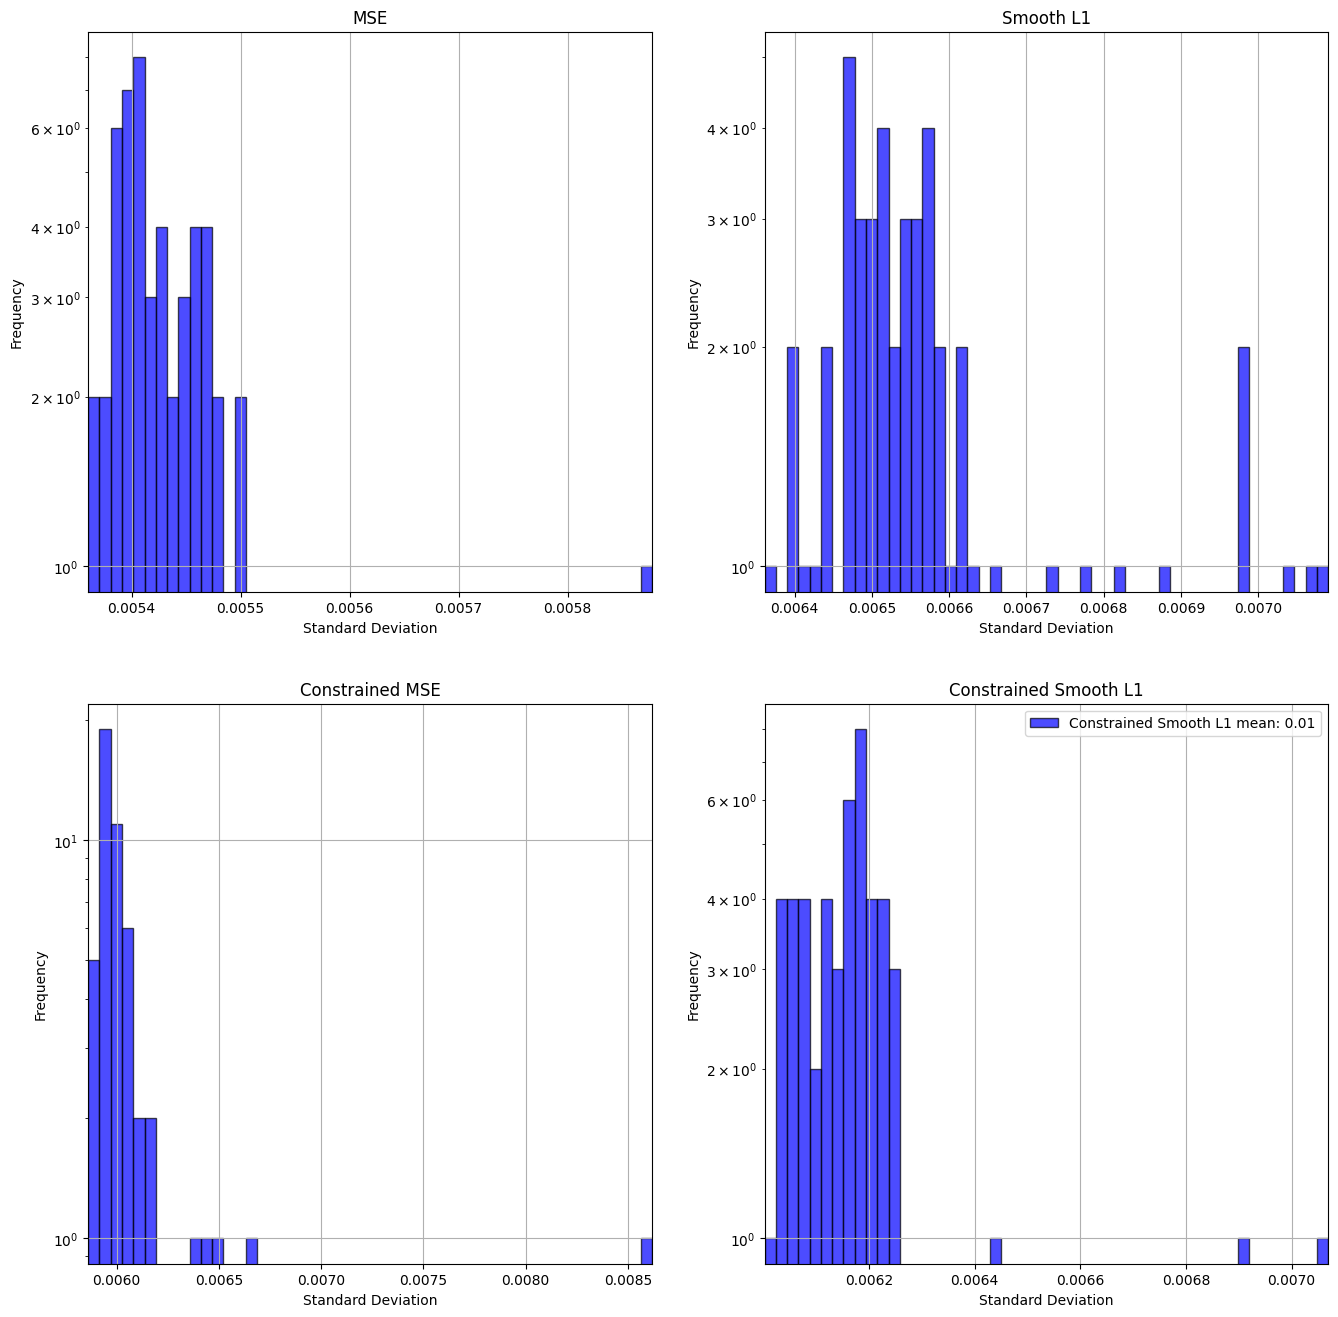

In [20]:
test_all_models()